---
title: "Assignment 4-2"
author: "Sangwon Ju, SNU GSPA"
date: 'DEC/18/2022'
format: 
    html:
        code-overflow: wrap
        code-fold: true
categories:
   "Machine Learning & Deep Learning for Data Science (2022 Fall)" 
---

Attention and LSTM, Seq2Seq, Transformer (Score: 84/100)

# Environment Setup

In [1]:
import os
# get current path
print(os.getcwd())
# change path
os.chdir("E:/OneDrive - SNU\(B) 대학원/수업/2022 2학기/데이터사이언스를위한머신러닝과딥러닝/과제4/HW4")
print(os.getcwd())

e:\OneDrive - SNU\(B) 대학원\수업\2022 2학기\데이터사이언스를위한머신러닝과딥러닝\과제4\HW4
E:\OneDrive - SNU\(B) 대학원\수업\2022 2학기\데이터사이언스를위한머신러닝과딥러닝\과제4\HW4


In [3]:
import math
import random
from pathlib import Path
import sys

from data.data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
"""
import modules you need
"""


'\nimport modules you need\n'

## Util

**Do NOT Modify** code blocks in this section

In [5]:
SEED = 1234
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
def train(model, iterator, optimizer, loss_fn, clip):    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        src = batch[0].to(DEVICE)
        trg = batch[1].to(DEVICE)        
        optimizer.zero_grad()
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip) 
        optimizer.step()        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [7]:
def evaluate(model, iterator, loss_fn):    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch[0].to(DEVICE)
            trg = batch[1].to(DEVICE)
            output = model(src, trg)
            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [8]:
def plot_history(history):
    plt.figure(figsize=(2 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_PPL'], label="train_PPL")
    plt.plot(history['val_PPL'], label="val_PPL")
    plt.xlabel("iterations")
    plt.ylabel("PPL")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Learning Rate")
    plt.plot(history['lr'], label="learning rate")
    plt.xlabel("iterations")
    plt.ylabel("LR")
    plt.show()

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [9]:
MAX_LENGTH = 10
BATCH_SIZE = 64

TRAIN_RATIO = 0.7 # train dataset ratio, should be a float in (0, 0.8]
VALID_RATIO = 0.8 - TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [14]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length = max_length
        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']
        
        print("\n")
        print("This is data example")
        print(random.choice(self.pairs))

        print("\n")
        print("This is index of PAD token for each language")
        print(f"fra {self.output_lang.word2index['PAD']}")
        print(f"eng {self.input_lang.word2index['PAD']}")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)
    
    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)
print("\n")
print(f"This is dataset_size: {len(dataset)}")
print(f"train_size: {train_size}")
print(f"valid_data: {valid_size}")
print(f"test_data: {len(test_data)}")

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803


This is data example
['tu me fais de l ombre .', 'you re blocking my light .']


This is index of PAD token for each language
fra 2803
eng 4345


This is dataset_size: 10599
train_size: 7419
valid_data: 1059
test_data: 2121


# 1. Seq2Seq model with Attention Mechanism

## Implement LSTM Seq2Seq Model

In [165]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(LSTMEncoder, self).__init__()
        
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)

    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need. (e.g. hidden states of encoder, etc.)
        '''
        ################### YOUR CODE ###################
        input_embed = self.embedding(input) # (batch, max_len, emb_dim)

        enc_hidden, (hidden_state, cell_state) = self.lstm(input_embed,(hidden, cell))
        hidden_state = hidden_state[0]
  
        return enc_hidden, hidden_state, cell_state  
        #################################################

In [166]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hid_dim, out_dim)

    def forward(self, input, hidden, cell):
        
        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention
        Before implementing LSTM layer, make sure to feed the concatenated input into Linear and tanh activation layer.
        This will allow the concatenated input to be resized from (B, hid_dim + hid_dim) into (B, hid_dim) 

        INPUT
        - input: a token of input sentence (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (N, emb_dim)
        - current hidden state
        - current cell state
        '''

        ################### YOUR CODE ###################
        query = hidden # set query to calculate attention
        query = torch.unsqueeze(query, dim=2) # (Batch, hidden, 1)
        key = self.enc_hiddens # (Batch, max_len, hid_dim)
        val = key.permute(0,2,1) # (Batch, hid_dim,max_len)
        
        attn_coef = F.softmax(torch.bmm(key, query),dim=1) # (Batch, max_len, 1)
        attn_val = torch.bmm(val, attn_coef).permute(0,2,1) # (Batch, 1, hid_dim)           
        input_embed = self.embedding(input)   
        
        # input: (Batch, 1, emb_dim + hid_dim)        
        hidden_cat = torch.cat([input_embed, attn_val], dim=2)
        
        # FC: (Batch, 1, hid_dim)  
        fc=self.fc
        tanh=self.tanh
        hidden_fc = fc(hidden_cat)
        hidden_act = tanh(hidden_fc)
        hidden_act = nn.Dropout(p=self.dropout)(hidden_act)                      
        
        # hiddens (Batch, 1, hid_dim), hidden_state (1, Batch, hid_dim), cell_state (1, Batch, hid_dim)
        hidden = torch.unsqueeze(hidden, dim = 0)     
        hiddens, (hidden_state, cell_state) = self.lstm(hidden_act, (hidden, cell))  
        hiddens = hiddens.permute(1,0,2)
        hidden_state = hidden_state[0]
        
        emb_pred = F.log_softmax(self.classifier(hiddens[0]),dim = 1) # (Batch, out_dim)
        
        return emb_pred, hidden_state, cell_state
        #################################################

In [167]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)
        
        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of one-hot prediction (B, out_dim, max_len)
        '''
        ################### YOUR CODE ###################
        batch_size, mx_len = src.shape
        DEVICE = self.device

        # Encoder (start from zero-hidden & zero-cell states)        
        hidden_state_0 = torch.zeros(1, batch_size, self.hid_dim).to(DEVICE)
        cell_state_0 = torch.zeros(1, batch_size, self.hid_dim).to(DEVICE)
        enc_hidden, hidden_state, cell_state = self.encoder(src, hidden_state_0, cell_state_0)

        # Decoder
        self.decoder.enc_hiddens = enc_hidden # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(DEVICE) # to store each decoder's output
        decodes = trg[:,[0]].to(DEVICE)        
        
        for t in np.arange(1, mx_len): # for each t'th token, get decoder outputs
            output, hidden_state, cell_state = self.decoder(decodes, hidden_state, cell_state)
            outputs[t] = output 
            decodes = trg[:,[t]].to(DEVICE)
                                           
        outputs = torch.permute(outputs,dims = (1,2,0))           
        return outputs
        #################################################

## Training

In [ ]:
'''
Q2 - (c)
Train your Seq2Seq model and plot perplexities and learning rates. 
Upon successful training, the test perplexity should be less than 7. 
Briefly report your hyperparameters and results on test dataset. 
Make sure your results are printed in your submitted file.
'''

In [171]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
emb_dim = 256
dropout = 0.3
learning_rate = 0.0005
N_EPOCHS = 30
valid_every= 5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

Epoch: 01
	Train Loss: 3.576 | Train PPL:  35.739
	 Val. Loss: 2.674 |  Val. PPL:  14.498
Epoch: 02
	Train Loss: 2.445 | Train PPL:  11.525
Epoch: 03
	Train Loss: 2.156 | Train PPL:   8.633
Epoch: 04
	Train Loss: 1.967 | Train PPL:   7.149
Epoch: 05
	Train Loss: 1.818 | Train PPL:   6.158
Epoch: 06
	Train Loss: 1.689 | Train PPL:   5.414
	 Val. Loss: 1.848 |  Val. PPL:   6.349
Epoch: 07
	Train Loss: 1.574 | Train PPL:   4.825
Epoch: 08
	Train Loss: 1.465 | Train PPL:   4.328
Epoch: 09
	Train Loss: 1.366 | Train PPL:   3.919
Epoch: 10
	Train Loss: 1.271 | Train PPL:   3.566
Epoch: 11
	Train Loss: 1.183 | Train PPL:   3.264
	 Val. Loss: 1.575 |  Val. PPL:   4.829
Epoch: 12
	Train Loss: 1.098 | Train PPL:   2.998
Epoch: 13
	Train Loss: 1.017 | Train PPL:   2.764
Epoch: 14
	Train Loss: 0.942 | Train PPL:   2.565
Epoch: 15
	Train Loss: 0.868 | Train PPL:   2.382
Epoch: 16
	Train Loss: 0.800 | Train PPL:   2.226
	 Val. Loss: 1.418 |  Val. PPL:   4.128
Epoch: 17
	Train Loss: 0.736 | Train PPL

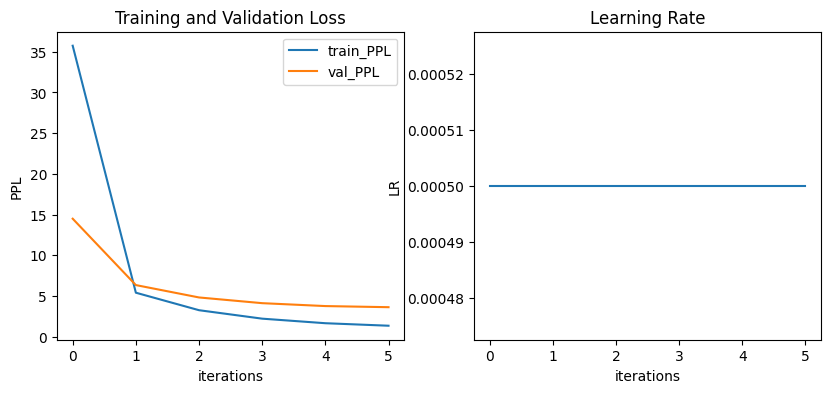

In [172]:
# Train your model 
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history) 

In [173]:
# Test your model
torch.save(model.state_dict(), 'lstm-attn-model.pt') 
loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 1.290 |  Test. PPL:   3.634


## [Bonus] Implement GRU Seq2Seq Model

In [ ]:
'''
Q2 - (d)
Change the modules(encoder, decoder) in Seq2Seq model to GRU, and repeat (a)~(c).

'''

In [175]:
class GRUEncoder(nn.Module):
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(GRUEncoder, self).__init__()
        ################### YOUR CODE ###################
        self.dropout_layer = nn.Dropout(p=dropout)
        self.embedding = nn.Embedding(in_dim, emb_dim)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)
        #################################################

    def forward(self, input, hidden):
        ################### YOUR CODE ###################
        input_embed = self.embedding(input) # (batch, max_len, emb_dim)
        input_embed = self.dropout_layer(input_embed)
        
        enc_hidden, hidden_state = self.gru(input_embed,hidden)
        hidden_state = hidden_state[0]
  
        return enc_hidden, hidden_state
        #################################################

In [176]:
class AttnGRUDecoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnGRUDecoder, self).__init__()
        ################### YOUR CODE ###################
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim)
        self.gru = nn.GRU(input_size=hid_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hid_dim + hid_dim, hid_dim)
        self.tanh = nn.Tanh()
        self.classifier = nn.Linear(hid_dim, out_dim)
        #################################################

    def forward(self, input, hidden):

        ################### YOUR CODE ###################
        query = hidden # set query to calculate attention
        query = torch.unsqueeze(query, dim=2) # (Batch, hidden, 1)
        key = self.enc_hiddens # (Batch, max_len, hid_dim)
        val = key.permute(0,2,1) # (Batch, hid_dim,max_len)
        
        attn_coef = F.softmax(torch.bmm(key, query),dim=1) # (Batch, max_len, 1)
        attn_val = torch.bmm(val, attn_coef).permute(0,2,1) # (Batch, 1, hid_dim)           
        input_embed = self.embedding(input) 
        
        # input: (Batch, 1, emb_dim + hid_dim)        
        hidden_cat = torch.cat([input_embed, attn_val], dim=-1)
                
        # FC: (Batch, 1, hid_dim)  
        fc=self.fc
        tanh=self.tanh
        hidden_fc = fc(hidden_cat)
        hidden_act = tanh(hidden_fc)
        
        hidden_act = nn.Dropout(p=self.dropout)(hidden_act) 
        
        # hiddens (Batch, 1, hid_dim), hidden_state (1, Batch, hid_dim)
        hidden = torch.unsqueeze(hidden, dim = 0)   
        hiddens, hidden_state = self.gru(hidden_act, hidden)  
        hiddens = hiddens.permute(1,0,2)
        hidden_state = hidden_state[0]
        
        emb_pred = F.log_softmax(self.classifier(hiddens[0]),dim = 1) # (Batch, out_dim)

        return emb_pred, hidden_state
        #################################################

In [177]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(GRUSeq2Seq, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = nn.Dropout(dropout)
        
        self.encoder = GRUEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnGRUDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        batch_size, mx_len = src.shape
        DEVICE = self.device
        
        ################### YOUR CODE ###################
        # Encoder
        hidden_state_0 = torch.zeros(1, batch_size, self.hid_dim).to(DEVICE)
        enc_hidden, hidden_state = self.encoder(src, hidden_state_0)
                
        # Decoder
        self.decoder.enc_hiddens = enc_hidden # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(DEVICE) # to store each decoder's output
        decodes = trg[:,[0]].to(DEVICE)   
        
        for t in np.arange(1, mx_len): # for each t'th token, get decoder outputs
            output, hidden_state = self.decoder(decodes, hidden_state)
            outputs[t] = output 
            decodes = trg[:,[t]].to(DEVICE)
                                           
        outputs = torch.permute(outputs,dims = (1,2,0))           
        return outputs
        #################################################

In [178]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words

hid_dim = 256
emb_dim = 256
dropout = 0.3
learning_rate = 0.001
N_EPOCHS = 30
valid_every = 3
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

Epoch: 01
	Train Loss: 3.076 | Train PPL:  21.672
	 Val. Loss: 2.423 |  Val. PPL:  11.282
Epoch: 02
	Train Loss: 2.149 | Train PPL:   8.579
Epoch: 03
	Train Loss: 1.831 | Train PPL:   6.238
Epoch: 04
	Train Loss: 1.626 | Train PPL:   5.084
	 Val. Loss: 1.786 |  Val. PPL:   5.963
Epoch: 05
	Train Loss: 1.462 | Train PPL:   4.316
Epoch: 06
	Train Loss: 1.317 | Train PPL:   3.734
Epoch: 07
	Train Loss: 1.195 | Train PPL:   3.303
	 Val. Loss: 1.571 |  Val. PPL:   4.812
Epoch: 08
	Train Loss: 1.089 | Train PPL:   2.971
Epoch: 09
	Train Loss: 0.995 | Train PPL:   2.705
Epoch: 10
	Train Loss: 0.914 | Train PPL:   2.493
	 Val. Loss: 1.477 |  Val. PPL:   4.382
Epoch: 11
	Train Loss: 0.843 | Train PPL:   2.324
Epoch: 12
	Train Loss: 0.777 | Train PPL:   2.176
Epoch: 13
	Train Loss: 0.717 | Train PPL:   2.049
	 Val. Loss: 1.423 |  Val. PPL:   4.149
Epoch: 14
	Train Loss: 0.663 | Train PPL:   1.941
Epoch: 15
	Train Loss: 0.617 | Train PPL:   1.853
Epoch: 16
	Train Loss: 0.571 | Train PPL:   1.770


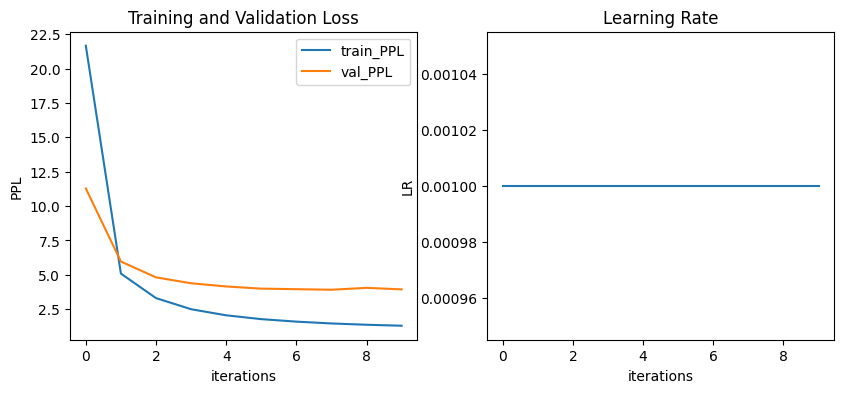

In [179]:
# Train your model 
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(gru_model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(gru_model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            gru_model.decoder.t=0
            torch.save(gru_model.state_dict(), 'gru-attn-model.pt')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history) 

In [180]:
# Test your model
torch.save(gru_model.state_dict(), 'gru-attn-model.pt') 
loaded_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
gru_model.load_state_dict(torch.load('gru-attn-model.pt'))

test_loss = evaluate(gru_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 1.370 |  Test. PPL:   3.937


# 2. Seq2Seq model with Transformer

## Implement Transformer Seq2Seq Model

In [10]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        self.hid_dim = hid_dim
        self.max_length = max_length
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        encoder_layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, src, pos_emb, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransEncoder Module
        (Use torch.nn.TransformerEncoder, torch.nn.TransformerEncoderLayer)
        
        INPUT
        - src: source language batched data (B, max_len)
        - pos_emb: positional embedding (1, max_len, hid_dim)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - encoder output (B, max_len, hid_dim)
        '''
        #################### YOUR CODE ####################
        batch_size = src.size(0)
        src_len = src.size(1)
        output = self.dropout(self.tok_embedding(src) * self.scale + pos_emb)
        enc_output =  self.encoder(output, src_key_padding_mask = src_mask)     
        # https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html  
        return enc_output
        ###################################################
        

In [11]:
class TransDecoder(nn.Module):
    def __init__(self, out_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        self.hid_dim = hid_dim
        self.max_length = max_length
        self.tok_embedding = nn.Embedding(out_dim, hid_dim)
        decoder_layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, n_layers)
        self.fc_out = nn.Linear(hid_dim, out_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, trg, pos_emb, enc_src, trg_mask, trg_sub_mask, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransDecoder Module
        (Use torch.nn.TransformerDecoder, torch.nn.TransformerDecoderLayer)
        
        INPUT
        - trg: target language batched data (B, max_len)
        - pos_emb: positional embedding (1, max_len, hid_dim)
        - enc_src: encoder outputs (B, max_len, hid_dim)
        - trg_mask: padding mask tensor for target sentences (B, max_len)
        - trg_sub_mask: subsequent mask for target sentences (max_len, max_len)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - decoder output (B, max_len, out_dim)
        '''
        #################### YOUR CODE ####################
        batch_size = trg.size(0)
        trg_len = trg.size(1)
        output = self.tok_embedding(trg) * self.scale + pos_emb
        dec_output = self.decoder(tgt=output, memory = enc_src, tgt_mask = trg_sub_mask, tgt_key_padding_mask = trg_mask, memory_key_padding_mask = src_mask)
        # https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html
        dec_output_fc = self.fc_out(dec_output)
        dec_output_fc = self.dropout(dec_output_fc)

        return dec_output_fc
        ###################################################

In [12]:
class TransSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout_p, device, max_length=MAX_LENGTH):
        super().__init__()
        
        self.device = device
        self.hid_dim = hid_dim
        self.max_length = max_length

        self.encoder = TransEncoder(in_dim, hid_dim, n_layers[0], n_heads, ff_dim, dropout_p, device)
        self.decoder = TransDecoder(out_dim, hid_dim, n_layers[1], n_heads, ff_dim, dropout_p, device)
        
    def make_src_mask(self, src):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - src: batched input sentences (B, max_len)

        OUTPUT
        - Boolean padding mask tensor (B, max_len)
        '''
        #################### YOUR CODE ####################
        DEVICE = self.device
        
        source_mask = (src == dataset.input_lang_pad)
        source_mask = source_mask.to(DEVICE)
        
        return source_mask
        ###################################################

    def make_trg_mask(self, trg):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - trg: batched target sentences (B, max_len)

        OUTPUT
        - A tuple of a padding mask tensor and a subsequent mask tensor ((B, max_len), (max_len, max_len))
        '''
        #################### YOUR CODE ####################
        DEVICE = self.device
        max_length = self.max_length
        
        target_mask = (trg == dataset.input_lang_pad)
        target_mask = target_mask.to(DEVICE)
        
        sub_mask = torch.triu(torch.ones((max_length,max_length)), diagonal=1).bool()
        sub_mask = sub_mask.to(DEVICE)

        return target_mask, sub_mask
        ###################################################

    def forward(self, src, trg):
        '''
        Q3 - (c)
        Implement forward method of TransSeq2Seq Module
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - decoder output (B, out_dim, max_dim)
        
        '''
        #################### YOUR CODE ####################
        src_mask = self.make_src_mask(src)
        trg_mask, trg_sub_mask = self.make_trg_mask(trg)
        pos_emb = self.get_pos_emb()
        enc_output = self.encoder(src=src, pos_emb=pos_emb, src_mask=src_mask)
        dec_output = self.decoder(trg=trg, pos_emb=pos_emb, enc_src=enc_output, trg_mask=trg_mask, trg_sub_mask=trg_sub_mask, src_mask=src_mask)
        dec_output = dec_output.permute((0, 2, 1))
        
        return dec_output
        ###################################################  
    
    def get_pos_emb(self):
        '''
        Q3 - (a)
        Implement absolute positional embedding

        OUTPUT
        - positional embedding tensor (max_len, hid_dim)
        '''
        #################### YOUR CODE ####################
        hid_dim = self.hid_dim 
        max_len = self.max_length 
        DEVICE = self.device
                
        embed_temp = torch.zeros((max_len, hid_dim))
        
        for k in np.arange(max_len):
            for i in np.arange(int(hid_dim/2)): 
                embed_temp[k, 2*i] = np.sin(k/np.power(10000, 2*i/hid_dim))
                embed_temp[k, 2*i+1] = np.cos(k/np.power(10000, 2*i/hid_dim))
                
        pos_emb = embed_temp.to(DEVICE)
        return pos_emb
        ###################################################

## Training

In [ ]:
'''
Q3 - (d)
Train your Seq2Seq model and plot perplexities and learning rates. 
Upon successful training, the test perplexity should be less than 2. 
Briefly report your hyperparmeters and results on test dataset. 
Make sure your results are printed in your submitted file.
'''

In [20]:
# experiment various methods for better performance
# you can modify the codes in this block
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
ff_dim = 256
n_enc_layers = 4
n_dec_layers = 4
n_layers = [n_enc_layers, n_dec_layers]
n_heads = 8
dropout = 0.3

learning_rate=0.001
N_EPOCHS =5
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trans_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
optimizer = torch.optim.Adam(trans_model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)

Epoch: 01
	Train Loss: 1.969 | Train PPL:   7.161
	 Val. Loss: 0.718 |  Val. PPL:   2.049
Epoch: 02
	Train Loss: 0.594 | Train PPL:   1.812
Epoch: 03
	Train Loss: 0.267 | Train PPL:   1.306
Epoch: 04
	Train Loss: 0.127 | Train PPL:   1.135
Epoch: 05
	Train Loss: 0.061 | Train PPL:   1.063


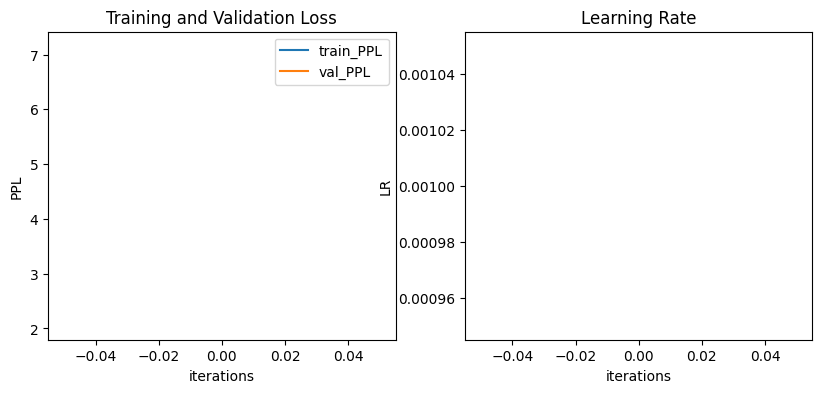

In [21]:
# Train your model
# you can modify the codes in this block
history = {'train_PPL':[], 'val_PPL':[], 'lr':[]}

for epoch in range(N_EPOCHS):
    train_loss = train(trans_model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(trans_model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            trans_model.decoder.t=0
            torch.save(trans_model.state_dict(), 'transformer-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

        history['train_PPL'].append(math.exp(train_loss))
        history['val_PPL'].append(math.exp(valid_loss))
        history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

In [22]:
# Test your model
torch.save(trans_model.state_dict(), 'transformer-model.pt') 
loaded_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
loaded_model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')

	 Test. Loss: 0.718 |  Test. PPL:   2.049
